# Audio Input on the fast ADC upload to Edge Impulse

This example shows how an audio signal can be captured using the fast input IN2.

Mercury is the Jupyter FPGA overlay for the Red Pitaya.

In [1]:
from redpitaya.overlay.mercury import mercury as overlay
import IPython.display as ipd
import matplotlib.pyplot as plt

#Audio processing requirements
import numpy as np
from scipy.io.wavfile import write

#Edge Impulse requirements
import json
import time, hmac, hashlib
import requests
import re, socket
import math

fpga = overlay()

Time taken to load BIN is 280.000000 Milli Seconds
BIN FILE loaded through FPGA manager successfully
Load overlay [OK].


Make an instance of the oscilloscope object is used for the input. The first argument is the channel index in range [0,1]. The second argument is the voltage range in volts, should be either 1.0 (default if unspecified) or 20.0. This is set to channel 1 (IN2) and 1.0 Volts the Low setting on the jumper.

In [2]:
in2 = fpga.osc(1, 1.0)

User should specify:
1. Sample rate decimation is an integer in range [1, 2\*\*17] = [1, 131072].
2. Number of samples stored before and after trigger, for a forced trigger only post trigger samples are enough.
3. Input level trigger source should (depending on the test purpose) be disabled (it is enabled by default)

30,000 samples per second is the minimum sample rate IPython.display will support. The minimum was chosen for this example to maximise the recording time using the oscilloscope object buffer.

In [3]:
# data rate decimation 
in2.decimation = 41667 #125 Msps / 41667 = 30 Ksps

# trigger timing [sample periods]
N = in2.buffer_size
in2.trigger_pre  = 0
in2.trigger_post = N

# disable hardware trigger sources - the Jupyter notebook will trigger the start of audio recording
in2.trig_src = 0

The oscilloscope should be reset, started, and a software trigger should be issued.
A loop is checking if the desired number of data samples was already stored in the buffer.

The same number of samples as the sum of pre/post trigger delays should be read from the buffer.
The data read is aligned to the last sample, which will be always present as the last sample in the returned array.

In [4]:
# synchronization and trigger sources are the default,
# which is the module itself
in2.reset()
in2.start()
in2.trigger()
# wait for data
while (in2.status_run()): pass
print ('Recording complete')
data = in2.data(N)

Recording complete


The audio data can then be displayed as an audio file that can be played or downloaded.

In [5]:
sr = 3000 # sample rate 3 Ksps
ipd.Audio(data, rate=sr) # load a NumPy array

Once the recording has been captured it can be displayed as a waveform.

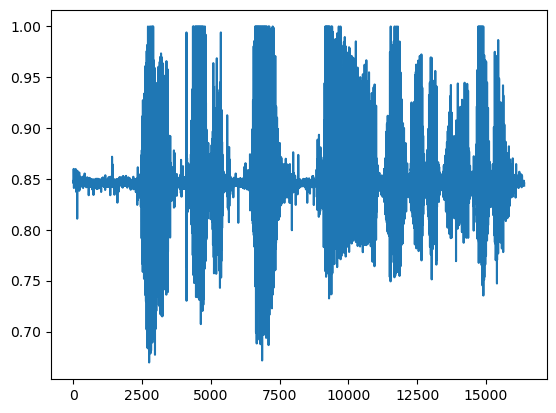

In [6]:
# show the part of the buffer requested by pre/post trigger timing - in this example the whole buffer.

plt.plot(data)
plt.show()

In [7]:
write("float_wave_test_raw.wav", sr, data)

In [8]:
# Install requests via: `pip3 install requests`
import requests
import os
from app_key import * #Import personal keys for the Edge Impulse project

# Add the files you want to upload to Edge Impulse
files = [
    'float_wave_test_raw.wav']
# # Replace the label with your own.
label = 'audio-test'
# Upload the file to Edge Impulse using the API, and print the response.
res = requests.post(url='https://ingestion.edgeimpulse.com/api/training/files',
                    headers={
                        'x-label': label,
                        'x-api-key': api_key,
                    },
                    # Creating the data payload for the request.
                    files=(('data', (os.path.basename(i), open(
                        i, 'rb'), 'audio/wav')) for i in files)
                    )

if (res.status_code == 200):
    print('Uploaded file(s) to Edge Impulse\n', res.status_code, res.content)
else:
    print('Failed to upload file(s) to Edge Impulse\n',
          res.status_code, res.content)

Uploaded file(s) to Edge Impulse
 200 b'{"success":true,"files":[{"success":true,"projectId":440448,"sampleId":1105253439,"fileName":"float_wave_test_raw.wav.53n1npro.json"}]}'
